# <font color='blue'>**PROYECTO: Control de Visitas Técnicas con Visión Computacional**

<font color='red'>Alba Ramirez    2216260 \\
<font color='red'>Milton Guarin   2210702

##<font color='blue'>Descripción del proyecto

Implementar un sistema de control con visión computacional, para controlar que los técnicos de instalaciones y reparaciones realicen realmente la visita al usuario, validando a través de una fotografía de la placa del predio que el numero de la placa coincida con el numero de la dirección entregada al técnico en la orden.



Para este proyecto utilizaremos técnicas de visión computacional tradicional con OPENCV para localizar la placa dentro de la imagen mediante identificación de contonos, posteriormente identificar el contorno de los caracteres y segmentarlos.  Luego a través de una CNN entrenada, realizar la clasificación de cada uno de esos caracteres y así identificar la placa del predio.

##<font color='blue'>Importamos las librerias necesarias

In [1]:
!pip install opencv-contrib-python==3.4.2.17

In [2]:
!pip install imutils

In [3]:
!pip install comet_ml

In [4]:
# Importamos las librerias necesarias

from comet_ml import Experiment
import os
import cv2
import glob
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
import tensorflow.keras.layers as layers
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

##<font color='blue'>Leer las imagenes almacenadas en Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
img_dir = '/content/drive/MyDrive/deteccion_placas/test'
file = img_dir + '/' + 'placa8.jpg'

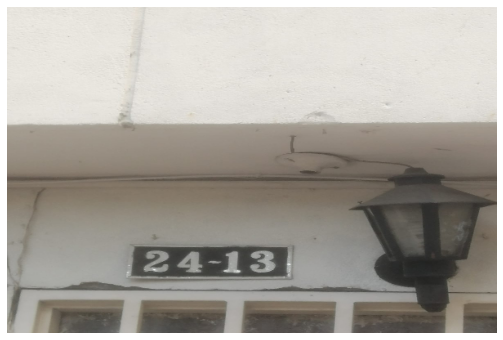

In [7]:
#Leer y mostrar las imagenes

def display(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.show()

img = cv2.imread(file)
img = cv2.resize(img, (600,400))
display(img)

##<font color='blue'>Preprocesamiento de imagenes

Utilizamos identificacion de contornos en la imagen con OPENCV para localizar la placa dentro de la imagen

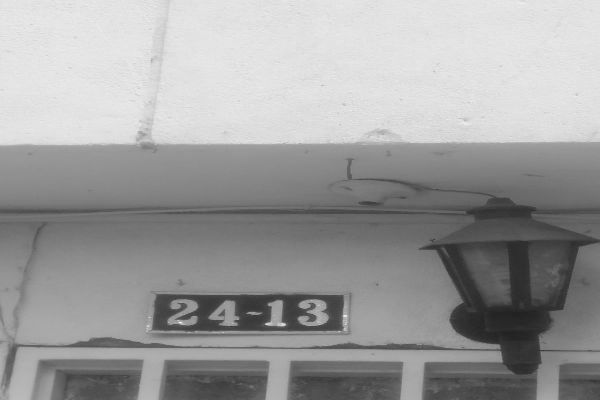

In [8]:
# Convertimos la imagen a escalas de grises

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_imshow(img_gray)

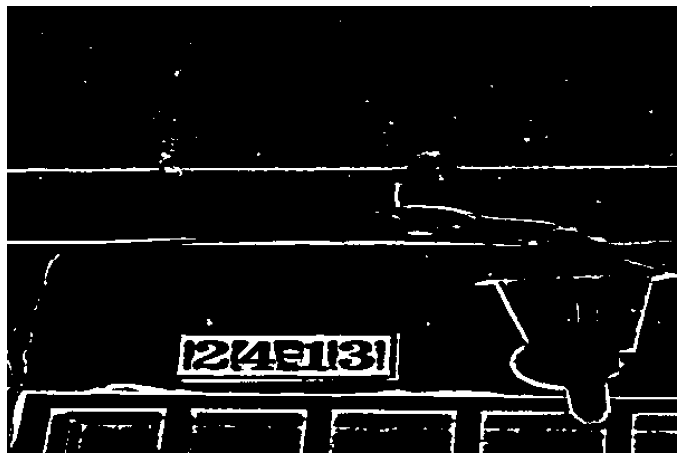

In [9]:
# Aplicamos filtros y encontramos los bordes para localizacion de la placa en la imagen

img_blurred = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
keypoints = cv2.findContours(img_thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [11]:
location=None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len (approx) == 4:
    location = approx
    break

In [12]:
location

array([[[152, 327]],

       [[341, 330]],

       [[343, 296]],

       [[156, 294]]], dtype=int32)

In [13]:
mask = np.zeros(img_gray.shape, np.uint8)
new_img = cv2.drawContours(mask, [location], 0,255,-1)
new_img = cv2.bitwise_and(img, img, mask=mask)

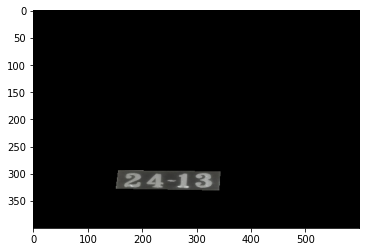

In [14]:
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

In [15]:
# Recortamos de la imagen general, la imagen de la placa solamente

(x,y) = np.where (mask==255)
(x1,y1) = (np.min(x), np.min(y))
(x2,y2) = (np.max(x), np.max(y))
cropped_img = img[x1:x2+1, y1:y2+1]

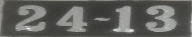

In [16]:
cv2_imshow(cropped_img)

##<font color='blue'>Identificamos los caracteres individuales en la imagen de la placa 

Utilizamos binarización de la imagen de la placa, transformación morfológica para cerrar la apertura del contorno de los caracteres e identificación de contornos de cada uno de los caracteres

In [17]:
# Encuentra caracteres en la imagen recortada (cropped_img)
def segment_characters(image) :

    # Preprocesa la imagen cortada de la placa con binarización
    img = cv2.resize(image, (333, 75))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Transformación morfologica para cerrar el shape de los digitos
    img_binary_lp = cv2.dilate(img_binary_lp, (2,2))
    kernel = np.ones((2,2), np.uint8)
    img_binary_lp = cv2.morphologyEx(img_binary_lp, cv2.MORPH_CLOSE, kernel)

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Genera bordes blancos
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estima el tamaño de los contornos de caracteres de las placas
    dimensions = [LP_WIDTH/5, LP_WIDTH/1, LP_HEIGHT/17, 2*LP_HEIGHT/3]
   
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Obtiene los cortornos de la imagen de la placa
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [18]:
def find_contours(dimensions, img) :
 
    # Encontrar todos los contornos de la imagen
    cntrs = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Recuperar las dimensiones
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    M = []
    cX = []
    cY = []
   
    # Verifica los 15 contornos mas grandes para identificar el contorno de los caracteres
    cntrs = imutils.grab_contours(cntrs)
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :

        # Detecta el contorno en coordenadas binarias y devuelve las coordenadas del rectangulo
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # comprobar las dimensiones del contorno para filtrar los caracteres por tamaño del contorno
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :

            x_cntr_list.append(intX) # Almacenas las coordenadas del contorno

            # Identificación de los centroides

            M = cv2.moments(cntr)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            #print(cX)
            
            char_copy = np.zeros((44,24))
            
            #Extrae cada caracter usando coordenadas del rectangulo
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
                      
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (0,255,0), 2)
            plt.imshow(ii, cmap='gray')

            # Resultado formateado para clasificacion
           #char = cv2.subtract(255, char)

            # Cambiar el tamaño de la imagen a 24x44 con borde negro
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # Lista que almacena la imagen binaria del caracter
            
    # Devuelve caracteres en orden ascendente con respecto a la coordenada x
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# Almacena las imagenes del caracter de acuerdo a su indice
    img_res = np.array(img_res_copy)

    return img_res

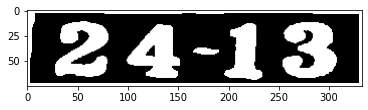

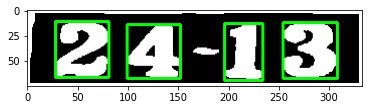

In [19]:
# Segmentación de los caracteres de la imagen recortada de la placa
char = segment_characters(cropped_img)

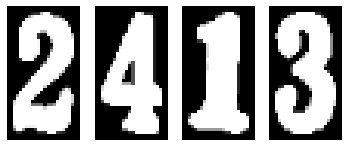

In [20]:
# Se separan los digitos de la imagen para identificarlos individualmente en el modelo
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

# <font color='blue'>Modelo CNN 

Se utiliza un modelo CNN basado en AlexNet para realizar la clasificación de cada uno de los caracteres

## <font color='blue'>Subimos del google drive el dataset de entrenamiento y validacion

El dataset consta de 1081 caracteres distribuidos en 36 clases:  Digitos del 0 al 9 y letras de la A a la Z

In [21]:
import pathlib
sld_dir = pathlib.Path('/content/drive/MyDrive/deteccion_placas/dataset/')
print(len(list(sld_dir.glob('*/*.jpg'))))

1081


Utilizamos el 80% del dataset para entrenamiento

In [22]:
# Settings:

batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  sld_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width), 
  batch_size=batch_size)

Found 1081 files belonging to 36 classes.
Using 865 files for training.


Utilizamos el 20% del dataset para validación

In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  sld_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1081 files belonging to 36 classes.
Using 216 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [27]:
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
X_train, Y_train = next(iter(norm_train_ds))

In [28]:
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
X_test, Y_test = next(iter(norm_val_ds))

##<font color='blue'>Implementación y entrenamiento del modelo

In [29]:
experiment = Experiment(
    api_key="BcmXvl5JtNiOK0G9U0pjgOTHE",
    project_name="visitas_tecnicas",
    workspace="mfguarin")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mfguarin/visitas-tecnicas/6f3bf2ac820b4638b55e8b64087102ac



In [30]:
tf.keras.backend.clear_session()

inputs = keras.Input(shape=(img_height, img_width, 3))

x = Conv2D(32, (5, 5), activation='relu',padding='valid')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
x = Conv2D(64, (1, 1), activation='relu',padding='valid')(x)
x = Conv2D(128, (1, 1), activation='relu',padding='valid')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(36, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       8320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0     

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [33]:
EPOCHS = 30
BATCH_SIZE = 32

In [34]:
from time import gmtime, strftime
time_stamp = strftime("%Y_%m_%d_%H_%M", gmtime())
experiment.set_name(time_stamp)

In [35]:
with experiment.train():
  history = model.fit(norm_train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=norm_val_ds, verbose=1)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/30


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


28/28 [==============================] - 11s 347ms/step - loss: 3.5242 - accuracy: 0.0486 - val_loss: 3.0102 - val_accuracy: 0.2454
Epoch 2/30
28/28 [==============================] - 9s 321ms/step - loss: 2.7141 - accuracy: 0.2254 - val_loss: 1.3850 - val_accuracy: 0.6296
Epoch 3/30
28/28 [==============================] - 9s 316ms/step - loss: 1.6014 - accuracy: 0.5272 - val_loss: 0.6483 - val_accuracy: 0.8611
Epoch 4/30
28/28 [==============================] - 9s 317ms/step - loss: 1.0306 - accuracy: 0.6821 - val_loss: 0.3073 - val_accuracy: 0.9306
Epoch 5/30
28/28 [==============================] - 9s 321ms/step - loss: 0.7301 - accuracy: 0.7642 - val_loss: 0.1977 - val_accuracy: 0.9352
Epoch 6/30
28/28 [==============================] - 9s 324ms/step - loss: 0.5022 - accuracy: 0.8347 - val_loss: 0.2086 - val_accuracy: 0.9630
Epoch 7/30
28/28 [==============================] - 9s 326ms/step - loss: 0.4361 - accuracy: 0.8624 - val_loss: 0.1590 - val_accuracy: 0.9491
Epoch 8/30
28/28

In [36]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/mfguarin/visitas-tecnicas/6f3bf2ac820b4638b55e8b64087102ac
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [30]          : (0.0485549122095108, 0.9722543358802795)
COMET INFO:     train_batch_accuracy [90]    : (0.017045455053448677, 1.0)
COMET INFO:     train_batch_loss [90]        : (0.020285028964281082, 3.5956978797912598)
COMET INFO:     train_epoch_duration [30]    : (8.773456943000042, 10.963401567000005)
COMET INFO:     train_loss [30]              : (0.07295124977827072, 3.5242254734039307)
COMET INFO:     train_val_accuracy [30]      : (0.24537037312984467, 0.9861111044883728)
COMET INFO:     train_val_loss [30]          : (0.05486764386296272, 3.0101945400238037)
COMET INFO:     validate_batch_accuracy [30] : (0

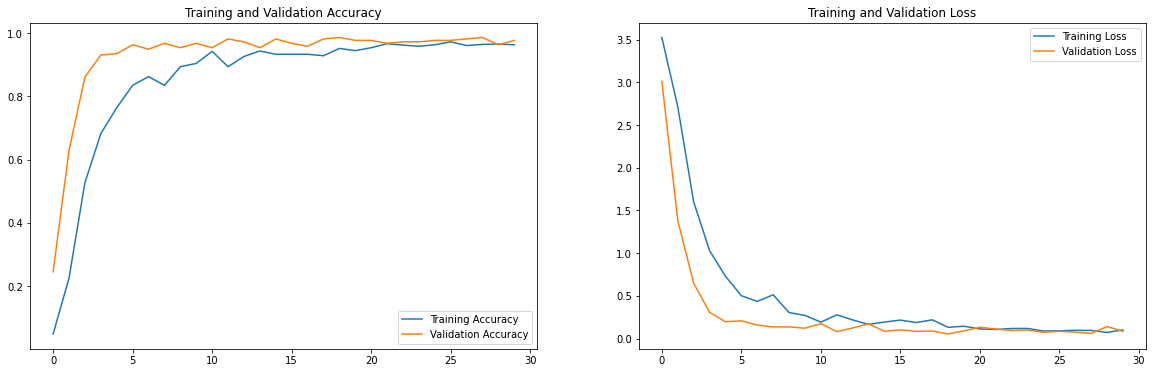

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range (EPOCHS)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model.save('cnn_basico.h5')

#<font color='blue'>Pruebas de clasificación de los caracteres en el set de pruebas de placas

In [39]:
#Directorio donde se almacen las imagenes de prueba

dir_test='/content/drive/MyDrive/deteccion_placas/test'
print(os.listdir(dir_test))

['placa2.jpg', 'placa3.jpg', 'placa1.jpg', 'placa8.jpg', 'placa9.jpg', 'placa11.jpg', 'placa15.jpg', 'placa16.jpg']


In [40]:
!rmdir /content/drive/MyDrive/deteccion_placas/test/.ipynb_checkpoints

rmdir: failed to remove '/content/drive/MyDrive/deteccion_placas/test/.ipynb_checkpoints': No such file or directory


##<font color='blue'>Carga y preprocesa la imagen

Se carga la imagen y se hace el procesamiento para convertirla a gris, suavizar, binarizar, detectar los bordes  y extraer la placa de la imagen original

In [41]:
test_ds = []

for file in os.listdir (dir_test):
  img_t = cv2.imread (dir_test + '/'+ file)
  img_t = cv2.resize(img_t, (600, 400))
  img_gray_t = cv2.cvtColor(img_t, cv2.COLOR_RGB2GRAY)
  img_blurred_t = cv2.GaussianBlur(img_gray_t, ksize=(3, 3), sigmaX=0)
  img_thresh_t = cv2.adaptiveThreshold(
    img_blurred_t, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
    )
  
  keypoints = cv2.findContours(img_thresh_t.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(keypoints)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

  location=None
  for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len (approx) == 4:
      location = approx
      break
  
  mask = np.zeros(img_gray_t.shape, np.uint8)
  new_img_t = cv2.drawContours(mask, [location], 0,255,-1)
  new_img_t = cv2.bitwise_and(img_t, img_t, mask=mask)

  (x,y) = np.where (mask==255)
  (x1,y1) = (np.min(x), np.min(y))
  (x2,y2) = (np.max(x), np.max(y))
  cropped_img_t = img_t[x1:x2+1, y1:y2+1]

  test_ds.append(cropped_img_t)

Se imprimen las imagenes de las placas ya recortas de las imagenes de prueba

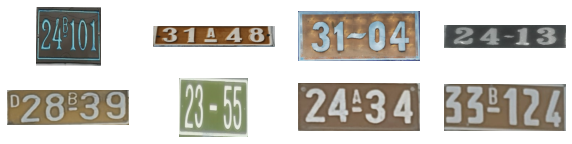

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(len(test_ds)):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(test_ds[i])
  i += 1

Segmenta cada uno de los caracteres de la imagen recortada y normaliza las imagenes de los caracteres para ingresarla al modelo CNN

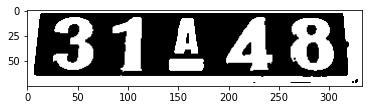

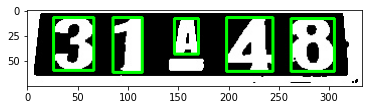

In [42]:
img_test = test_ds[1]
char_test = segment_characters(img_test)

In [43]:
def fix_dimension(img): 
  new_img = np.zeros((64,64,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

In [44]:
# Utiliza el modelo para clasificar las imagenes de los numeros

def fix_dimension(img): 
  new_img = np.zeros((64,64,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char_test): #iteraccion sobre los cada uno de los caracteres
        img_ = cv2.resize(ch, (64,64), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,64,64,3) #Prepera la imagen para ingresar al modelo

        pred = model.predict(img)[0] # Realiza la clasificación
        pred = np.argmax(pred,axis=0)

        character = dic[pred]
        output.append(character) # Guarda el resultado en una lista
       
    numero_placa = "".join([str(n) for n in output])
    
    return numero_placa

print('El numero de la placa es:', show_results())

El numero de la placa es: 31A4B


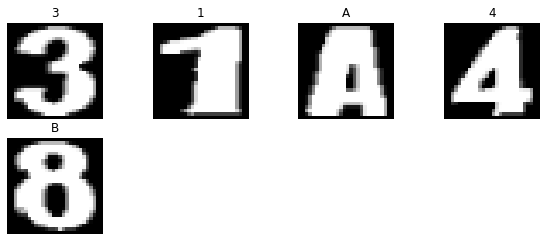

In [45]:
# Segmenta los caracteres de la placa y su clasificación
plt.figure(figsize=(10,6))
for i,ch in enumerate(char_test):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    title_obj = plt.title(show_results()[i])
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()